# HIPT TCGA BRCA Dataset Curation

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import Markdown as md

pd.set_option('mode.chained_assignment', None)

### Load HIPT slides

In [2]:
hipt_dir = Path('/data/pathology/projects/ais-cap/code/git/opensource/HIPT')

In [3]:
fold_0_fp = Path(hipt_dir, '2-Weakly-Supervised-Subtyping/splits/10foldcv_subtype/tcga_brca/splits_0.csv')

In [4]:
df = pd.read_csv(fold_0_fp, index_col=0)
df.head()

,train,val,test
0,TCGA-A7-A6VV-01Z-00-DX1.07AE0E16-A883-4C86-BC7...,TCGA-A2-A0YH-01Z-00-DX1.FBA5E711-8275-45B3-BC2...,TCGA-BH-A202-01Z-00-DX1.8CECDB74-5E6F-4CE8-B52...
1,TCGA-A2-A0T1-01Z-00-DX1.CD1E9C46-18A3-466B-AA0...,TCGA-BH-A0E1-01Z-00-DX1.257EB36A-1008-4890-927...,TCGA-D8-A1JB-01Z-00-DX1.6CF48257-066C-4B8C-91A...
2,TCGA-BH-A0B9-01Z-00-DX1.C23ADB4C-52D4-4DFD-B8E...,TCGA-BH-A0W5-01Z-00-DX1.84EA3913-667B-4694-A0F...,TCGA-OL-A5RX-01Z-00-DX1.15A0D4F4-2744-4D44-888...
3,TCGA-A2-A0ET-01Z-00-DX1.41E86BB9-EA52-4615-94E...,TCGA-AQ-A0Y5-01Z-00-DX1.f68f5b49-30fa-4fb6-bec...,TCGA-BH-A0EE-01Z-00-DX1.872EA586-25C8-4835-A13...
4,TCGA-C8-A26Z-01Z-00-DX1.1A15D951-F3BD-4024-91D...,TCGA-A8-A08C-01Z-00-DX1.0602211C-1098-4711-AA4...,TCGA-EW-A2FW-01Z-00-DX1.4F948681-81F3-46C5-A4E...


In [5]:
hipt_train_brca = list(df['train'].dropna().unique())
hipt_tune_brca = list(df['val'].dropna().unique())
hipt_test_brca = list(df['test'].dropna().unique())

len(hipt_train_brca), len(hipt_tune_brca), len(hipt_test_brca)

(845, 98, 98)

In [6]:
hipt_train_brca = set(hipt_train_brca)
hipt_tune_brca = set(hipt_tune_brca)
hipt_test_brca = set(hipt_test_brca)

In [7]:
intersection_train_tune = hipt_train_brca.intersection(hipt_tune_brca)
intersection_train_test = hipt_train_brca.intersection(hipt_test_brca)
intersection_tune_test = hipt_tune_brca.intersection(hipt_test_brca)

len(intersection_train_tune), len(intersection_train_test), len(intersection_tune_test)

(0, 0, 0)

In [8]:
hipt_brca = hipt_train_brca | hipt_tune_brca | hipt_test_brca
len(hipt_brca)

1041

In [9]:
list(hipt_brca)[0]

'TCGA-A7-A26H-01Z-00-DX1.3344CFD3-5A19-4B01-BEB2-AB89F83FD53A'

### Load Blissey slides

In [10]:
data_dir = Path('/data/pathology/archives/breast/TCGA_diagnostics/')

In [11]:
blissey_brca = list(Path(data_dir, 'images').glob('*.tif')) + list(Path(data_dir, 'clement_slides/tif').glob('*.tif'))
blissey_brca = [s.stem for s in blissey_brca]
blissey_brca[0]

'TCGA-GM-A2D9-01Z-00-DX1.AF4BF2DD-05FB-400B-A1BC-6E7C9B9DDF05'

In [12]:
len(blissey_brca)

1126

In [13]:
blissey_brca = set(blissey_brca)
len(blissey_brca)

1126

### Compare HIPT & Blissey slides

In [14]:
intersection_hipt_blissey = hipt_brca.intersection(blissey_brca)
print(f'{len(intersection_hipt_blissey)}/{len(hipt_brca)}') 

1034/1041


In [15]:
difference_hipt_blissey = hipt_brca.difference(blissey_brca)
md(f'there are **{len(difference_hipt_blissey)}** slides from HIPT dataset that are not on Blissey')

there are **7** slides from HIPT dataset that are not on Blissey

### Load HIPT labels

In [16]:
hipt_labels_csv_path = Path(hipt_dir, '2-Weakly-Supervised-Subtyping/dataset_csv/tcga_brca_subset.csv.zip')
hipt_labels_df = pd.read_csv(hipt_labels_csv_path, index_col=0)
hipt_labels_df.head()

,case_id,slide_id,age,site,survival_months,censorship,is_female,oncotree_code,train,CDH1_mut,...,PIK3CA_mut,PTEN_mut,RYR2_mut,SPTA1_mut,SYNE1_mut,TP53_mut,TTN_mut,USH2A_mut,ZFHX4_mut,RAS_mut
0,TCGA-3C-AALI,TCGA-3C-AALI-01Z-00-DX1.F6E9A5DF-D8FB-45CF-B4B...,50.0,3C,131.57,1.0,1.0,IDC,1.0,0,...,0,0,1,1,0,1,1,0,1,0
1,TCGA-3C-AALI,TCGA-3C-AALI-01Z-00-DX2.CF4496E0-AB52-4F3E-BDF...,50.0,3C,131.57,1.0,1.0,IDC,1.0,0,...,0,0,1,1,0,1,1,0,1,0
2,TCGA-3C-AALJ,TCGA-3C-AALJ-01Z-00-DX1.777C0957-255A-42F0-9EE...,62.0,3C,48.42,1.0,1.0,IDC,1.0,0,...,0,0,0,0,0,0,1,0,1,0
3,TCGA-3C-AALJ,TCGA-3C-AALJ-01Z-00-DX2.62DFE56B-B84C-40F9-962...,62.0,3C,48.42,1.0,1.0,IDC,1.0,0,...,0,0,0,0,0,0,1,0,1,0
4,TCGA-3C-AALK,TCGA-3C-AALK-01Z-00-DX1.4E6EB156-BB19-410F-878...,52.0,3C,47.57,1.0,1.0,IDC,1.0,0,...,1,0,0,0,0,0,0,0,0,0


In [17]:
len(hipt_labels_df)

937

In [18]:
hipt_labels_df['slide_id'].dropna().nunique()

937

why do we only have labels for **937** slides?

In [19]:
# drop .tif from slide ids
hipt_labels_df['slide_id'] = hipt_labels_df['slide_id'].apply(lambda x: Path(x).stem)

In [20]:
hipt_labels_df.oncotree_code.value_counts(dropna=False)

IDC       726
ILC       149
MDLC       25
IMMC       12
MBC        11
BRCA        5
PD          3
ACBC        2
SPC         2
BRCNOS      1
MPT         1
Name: oncotree_code, dtype: int64

In [21]:
hipt_fold_labels_df = hipt_labels_df[hipt_labels_df['slide_id'].isin(hipt_brca)]
hipt_fold_labels_df.slide_id.dropna().nunique()

875

among the 937 slides for which we have labels, only **875** are used for training/tuning/testing<br>
this is because we drop all labels that are not IDC or ILC

In [22]:
hipt_fold_labels_df.oncotree_code.value_counts(dropna=False)

IDC    726
ILC    149
Name: oncotree_code, dtype: int64

In [23]:
def map_otc_to_int(otc: str, missing_label: int = -1):
    if otc == 'IDC':
        return 0
    elif otc == 'ILC':
        return 1
    else:
        return missing_label

In [24]:
hipt_fold_labels_df['label'] = hipt_fold_labels_df['oncotree_code'].apply(map_otc_to_int)

### Get HIPT slide count per case_id

In [25]:
list(hipt_brca)[0]

'TCGA-A7-A26H-01Z-00-DX1.3344CFD3-5A19-4B01-BEB2-AB89F83FD53A'

In [26]:
def extract_case_id_from_slide_id(slide_id):
    return '-'.join(slide_id.split('-')[:3])

extract_case_id_from_slide_id(list(hipt_brca)[0])

'TCGA-A7-A26H'

In [27]:
hipt_brca_case_ids = [extract_case_id_from_slide_id(s) for s in hipt_brca]
len(hipt_brca_case_ids), len(set(hipt_brca_case_ids))

(1041, 977)

Hence, we have some slides mapped to the same case ids

In [28]:
duplicated_hipt_brca_case_ids = set([c for c in hipt_brca_case_ids if hipt_brca_case_ids.count(c) > 1])
md(f'there are **{len(duplicated_hipt_brca_case_ids)}** case ids mapped to 2+ slides')

there are **59** case ids mapped to 2+ slides

In [29]:
d = {'case_id': [], 'nslide': []}
for case_id in set(hipt_brca_case_ids):
    d['case_id'].append(case_id)
    d['nslide'].append(hipt_brca_case_ids.count(case_id))
tmp = pd.DataFrame.from_dict(d)
tmp.head()

,case_id,nslide
0,TCGA-C8-A26X,1
1,TCGA-GM-A4E0,1
2,TCGA-BH-A0HY,1
3,TCGA-D8-A27L,1
4,TCGA-A8-A07F,1


In [30]:
tmp.nslide.sum()

1041

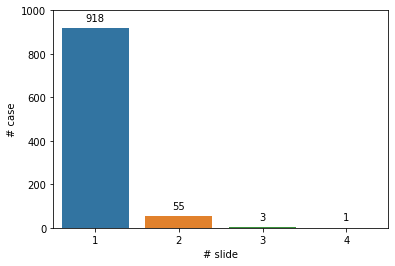

In [31]:
ax = sns.countplot(data=tmp, x='nslide')
ax.bar_label(ax.containers[0], padding=5)
plt.xlabel('# slide')
plt.ylabel('# case')
plt.ylim(0,1000)
plt.show()

Investigate labels when multiple slides available

In [32]:
tmp = hipt_fold_labels_df[hipt_fold_labels_df['case_id'].isin(duplicated_hipt_brca_case_ids)]
tmp.oncotree_code.value_counts(dropna=False)

IDC    78
ILC    12
Name: oncotree_code, dtype: int64

question: is there a case_id whith 2+ slides whose labels are different?

In [33]:
tmp_df = (tmp.groupby('case_id')['oncotree_code'].nunique() > 1).reset_index()
tmp_df = tmp_df.rename(columns={'oncotree_code': 'multiple_labels'})
tmp_df.head()

,case_id,multiple_labels
0,TCGA-3C-AALI,False
1,TCGA-3C-AALJ,False
2,TCGA-A7-A0CD,False
3,TCGA-A7-A0CE,False
4,TCGA-A7-A0CH,False


In [34]:
tmp = tmp_df[tmp_df['multiple_labels'] == True]
len(set(tmp.case_id))

0

answer is **no**<br>
to extract some information from this, we'd need to know how these labels were actually curated<br>
e.g. whether patient/case level label was replicated for each slide (when 2+ slides available)

### Wrapping up

In [35]:
hipt_fold_labels_df.case_id.dropna().nunique(), hipt_fold_labels_df.slide_id.dropna().nunique()

(837, 875)

if one sticks to their _labeled_ dataset: **837** patients mapped to **875** slides

In [36]:
# how many of these 875 slides are missing on the cluster?

hipt_brca_labeled = set(hipt_fold_labels_df.slide_id.dropna().tolist())
len(hipt_brca_labeled)

875

In [37]:
intersection_hipt_labeled_blissey = hipt_brca_labeled.intersection(blissey_brca)
print(f'{len(intersection_hipt_labeled_blissey)}/{len(hipt_brca_labeled)}')

875/875


From HIPT github repo ([see here](https://github.com/mahmoodlab/HIPT/issues/6#issuecomment-1175792504)):

> Files under `HIPT/2-Weakly-Supervised-Subtyping/dataset_csv/` contain the total list of WSIs evaluated. Though there are more patients included in the `10foldcv_subtype/tcga_brca/split_{i}.csv` split, patients with insufficient tissue content for patching at the 4K-level and are thus missing in the pt_files-type folder, get excluded / masked out when slicing the dataframe. I should update the split csv files to clarify this confusion.

Issues Watchlist:

- https://github.com/mahmoodlab/HIPT/issues/11 has GDC manifest text files
- https://github.com/mahmoodlab/HIPT/issues/16 question regarding BRCA subtyping labels

Dump slide filenames in .txt file

In [38]:
list(hipt_brca_labeled)[0]

'TCGA-A7-A26H-01Z-00-DX1.3344CFD3-5A19-4B01-BEB2-AB89F83FD53A'

In [39]:
with open(f'../tcga_brca.txt', 'w') as f:
    for slide in hipt_brca_labeled:
        f.write(f'{slide}.tif\n')